In [1]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np
import ineqpy
import matplotlib.pyplot as plt
from os import path
import main as sugar

import time
from IPython.display import clear_output

runstorun = [1920, 2399] # lower and upper, both inclusive!
nsamples = 600
data_dir = "data_sensanalysis/"
runsfilename = f"data_sensanalysis/sensitivity_analysis_{nsamples}_runs_{runstorun[0]}_{runstorun[1]}.npy"
samplesfilename = f"data_sensanalysis/sensitivity_analysis_{nsamples}_samples.npy"

In [2]:
# Define the model inputs
problem = {
    'num_vars': 6,
    'names': ['N agents', 'vision', 'Total initial sugar', 'Use Amsterdam map', "Use death", "Use instant regrowth"],
    'bounds': [[50, 250], # NAgents
               [1, 10], #Vision
               [1, 10], #Total init sugar
               [0, 1], #Amsterdam map
               [0, 1], #Death
               [0, 1]] #Instant_regrowth
}

# load samples if exist, otherwise create
samples = None
if path.exists(samplesfilename):
    samples = np.load(samplesfilename)
    print("Samples found and loaded")
else:
    # Generate samples
    samples = saltelli.sample(problem, nsamples, calc_second_order=False) # 1000 samples
    np.save(samplesfilename, samples)
    print("Samples created and saved")

print(len(samples)," runs todo, first 10:\n",samples[:10])

Samples found and loaded
4800  runs todo, first 10:
 [[9.39453125e+01 1.87011719e+00 5.66699219e+00 6.76757812e-01
  2.80273438e-01 9.07226562e-01]
 [5.91796875e+01 1.87011719e+00 5.66699219e+00 6.76757812e-01
  2.80273438e-01 9.07226562e-01]
 [9.39453125e+01 9.09472656e+00 5.66699219e+00 6.76757812e-01
  2.80273438e-01 9.07226562e-01]
 [9.39453125e+01 1.87011719e+00 5.50878906e+00 6.76757812e-01
  2.80273438e-01 9.07226562e-01]
 [9.39453125e+01 1.87011719e+00 5.66699219e+00 6.93359375e-02
  2.80273438e-01 9.07226562e-01]
 [9.39453125e+01 1.87011719e+00 5.66699219e+00 6.76757812e-01
  8.49609375e-02 9.07226562e-01]
 [9.39453125e+01 1.87011719e+00 5.66699219e+00 6.76757812e-01
  2.80273438e-01 2.54882812e-01]
 [5.91796875e+01 9.09472656e+00 5.50878906e+00 6.93359375e-02
  8.49609375e-02 2.54882812e-01]
 [1.93945312e+02 6.37011719e+00 1.16699219e+00 1.76757812e-01
  7.80273438e-01 4.07226562e-01]
 [1.59179688e+02 6.37011719e+00 1.16699219e+00 1.76757812e-01
  7.80273438e-01 4.07226562e-0

In [3]:
# function to run the model with the desired parameters
def runmodel(params):
    # set parameters
    N = int(round(params[0]))
    vision = int(round(params[1]))
    total_init_sugar = params[2]
    
    # convert floats between 0 and 1 to booleans
    useamsmap = True
    if int(round(params[3])) == 0:
        useamsmap = False
    usedeath = True
    if int(round(params[4])) == 0:
        usedeath = False
    useinstantregrowth = True
    if int(round(params[5])) ==0:
        usedeath = False

    tax_rate = 1
    parameters = N, vision, total_init_sugar, useamsmap, usedeath, useinstantregrowth, tax_rate

    print("parameters:\n",parameters)

    # run model
    df = sugar.main(parameters)
    df = df.reset_index()
    
    # extract avg gini from last 50 timestep
    ginis = []
    maxstep = max(df["Step"].tolist())
    for step in range(maxstep-49, maxstep+1):
        wealth = np.array(df.loc[(df.Step == step)]["Wealth"].tolist() )
        gini = ineqpy.gini(np.array(wealth))
        ginis.append(gini)
    
    return np.mean(ginis)

# because only very sometimes the model gives an non-reproducible error
def runmodel2(params):
    try:
        return runmodel(params)
    except:
        print("error encountered, trying again!")
        return runmodel2(params)

# Run simulations

In [4]:
# load runsfile if exists
runs = None
if path.exists(runsfilename):
    runs = np.load(runsfilename)
    print("Runs found and loaded")
else:
    runs = ["NaN"] * len(samples)
    np.save(runsfilename, runs)
    print("Runs file created and saved")

runs_todo = [i for i, x in enumerate(runs) if x == "NaN" and i >= runstorun[0] and i<= runstorun[1]]

Runs found and loaded


In [5]:
calculation_durations = []
failed_runs = []
for i, run in enumerate(runs_todo):
    
    start = time.perf_counter()
    
    try:
        runs[run] = runmodel(samples[run])
    except:
        failed_runs.append(run)
        
    np.save(runsfilename, runs)
    
    stop =  time.perf_counter()
    calculation_durations.append(stop - start)
    
    clear_output(wait=False)
    
    print("Eta (seconds): ", round((len(runs_todo) - (i + 1)) * np.mean(calculation_durations)))
    print("Progress:      ", i+1, "/", len(runs_todo))

    print("Runs failed:   ", failed_runs)

# Analysis

In [6]:
# load multiple run files and merge

from os import listdir
from os.path import isfile, join

print(f"sensitivity_analysis_{nsamples}_runs")
data_dir = "data_sensanalysis/"
rundata_filenames = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
rundata_filenames = [f for f in rundata_filenames if f.startswith(f"sensitivity_analysis_{nsamples}_runs")]

print(rundata_filenames)

ginis = ["NaN"] * len(runs)
for file in rundata_filenames:
    rundata = np.load(data_dir + file)
    for i, result in enumerate(rundata):
        if result != "NaN":
            ginis[i] = result
ginis = np.array(ginis).astype(np.float)
print(rundata_filenames, " loaded")
# print(ginis)
print(len(ginis), "Should equal", len(samples))

sensitivity_analysis_600_runs
['sensitivity_analysis_600_runs_0_479.npy', 'sensitivity_analysis_600_runs_1440_1919.npy', 'sensitivity_analysis_600_runs_1920_2399.npy', 'sensitivity_analysis_600_runs_2400_2879.npy', 'sensitivity_analysis_600_runs_2880_3359.npy', 'sensitivity_analysis_600_runs_3360_3839.npy', 'sensitivity_analysis_600_runs_3840_4319.npy', 'sensitivity_analysis_600_runs_4320_4799.npy', 'sensitivity_analysis_600_runs_480_959.npy', 'sensitivity_analysis_600_runs_960_1439.npy']
['sensitivity_analysis_600_runs_0_479.npy', 'sensitivity_analysis_600_runs_1440_1919.npy', 'sensitivity_analysis_600_runs_1920_2399.npy', 'sensitivity_analysis_600_runs_2400_2879.npy', 'sensitivity_analysis_600_runs_2880_3359.npy', 'sensitivity_analysis_600_runs_3360_3839.npy', 'sensitivity_analysis_600_runs_3840_4319.npy', 'sensitivity_analysis_600_runs_4320_4799.npy', 'sensitivity_analysis_600_runs_480_959.npy', 'sensitivity_analysis_600_runs_960_1439.npy']  loaded
4800 Should equal 4800


Parameter S1 S1_conf ST ST_conf
N agents 0.014723 0.019314 0.021482 0.004633
vision 0.213922 0.060458 0.326272 0.046327
Total initial sugar 0.009087 0.011261 0.008036 0.001768
Use Amsterdam map 0.137635 0.048615 0.216365 0.035867
Use death 0.160433 0.076276 0.400065 0.063587
Use instant regrowth 0.166253 0.075544 0.392303 0.062248


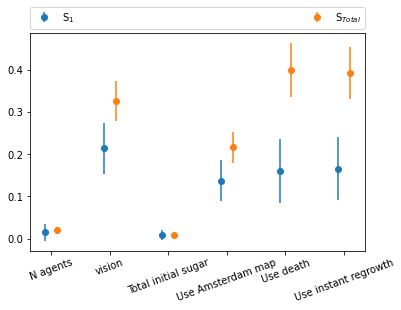

In [7]:
# Perform analysis
Si = sobol.analyze(problem, ginis, print_to_console=True, calc_second_order=False)

S1 = Si['S1']
S1_conf = Si['S1_conf']

ST = Si['ST']
ST_conf = Si['ST_conf']

plt.errorbar([val - 0.1 for val in np.arange(len(S1))], S1, yerr=S1_conf, fmt='o', label = r"S$_{1}$")
plt.errorbar([val + 0.1 for val in np.arange(len(ST))], ST, yerr=ST_conf, fmt='o', label = "S$_{Total}$")
plt.xticks(np.arange(len(S1)), problem["names"], rotation=20)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
plt.savefig("plt_sobol.pdf", format = "pdf", bbox_inches = 'tight')
plt.show()